In [69]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import os

def load_data() -> dict[str, pd.DataFrame]:
	"""
	Load data from CSV files in the 'csv' directory and return a dictionary of DataFrames.

	Returns:
		dict[str, pd.DataFrame]: A dictionary where the keys are the names of the CSV files
		(extracted from the file names) and the values are the corresponding DataFrames.
	"""
	data = {}
	for file in os.listdir("csv"):
		if file.startswith("predictions"):
			name = file.split("_")[1:]
			name = "_".join(name).split(".")[0]
			data[name] = pd.read_csv("csv/" + file)
	return data

In [70]:
dfs = load_data()

In [71]:
def calculate_metrics(dfs: dict[str, pd.DataFrame]):
	metrics = {}
	for model_name, df in dfs.items():
		predictions = df["predictions"]
		actuals = df["actual"]

		errors = predictions - actuals
		mape = (errors.abs() / actuals.abs()).mean() * 100
		std = (errors.abs() / actuals.abs()).std() * 100

		metrics[model_name] = {"MAPE": mape, "STD": std}
	
	return metrics

def plot_MAPE(metrics, std: bool = True):
	df_metrics = pd.DataFrame(metrics).T
	fig, ax = plt.subplots(figsize=(12, 8))
	
	df_metrics.sort_values('MAPE', ascending=False, inplace=True)
	colors = sns.color_palette('hls', len(df_metrics))
	if std:
		bars = ax.barh(df_metrics.index, df_metrics['MAPE'], xerr=df_metrics['STD'], capsize=4, color=colors)
	else:
		bars = ax.barh(df_metrics.index, df_metrics['MAPE'], color=colors)
	ax.set_xlabel('MAPE (%)')
	ax.set_title('Model Metrics')

	if std:
		for bar, std in zip(bars, df_metrics['STD']):
			width = bar.get_width()
			ax.text(width * 1.001, bar.get_y() + bar.get_height() / 2 * 1.25, f'{std:.2f}', ha='left', va='center')
	else:
		for bar in bars:
			width = bar.get_width()
			ax.text(width, bar.get_y() + bar.get_height() / 2, f'{width:.2f}', ha='left', va='center')

	plt.grid(axis='x', linestyle='--', alpha=0.6)
	plt.show()
	
def plot_errors(dfs: dict[str, pd.DataFrame], log_scale: bool = False, models: list[str] = None):
	plt.figure(figsize=(10, 6))
	colors = sns.color_palette("hls", len(dfs) if not models else len(models))
	idx = 0
	for model_name, df in dfs.items():
		if models and model_name not in models:
			continue
		df = dfs[model_name]
		errors = df["predictions"] - df["actual"]
		df["mape"] = (errors.abs() / df["actual"].abs()) * 100
		if log_scale:
			bins = np.logspace(np.log10(df["actual"].min()), np.log10(df["actual"].max()), 15)
			df["time_bins"] = pd.cut(df["actual"], bins)
			cum_mape = df.groupby("time_bins", observed=False)["mape"].mean()
			
			bin_centers = (bins[:-1] + bins[1:]) / 2
			plt.bar(bin_centers, cum_mape, width=np.diff(bins), label=model_name, alpha=0.6,align="center", color=colors[idx])
		else:
			bins = np.linspace(df["actual"].min(), df["actual"].max(), 15)
			df["time_bins"] = pd.cut(df["actual"], bins)
			cum_mape = df.groupby("time_bins", observed=False)["mape"].mean()
			
			bin_centers = (bins[:-1] + bins[1:]) / 2
			plt.bar(bin_centers, cum_mape, width=np.diff(bins), label=model_name, alpha=0.6,align="center", color=colors[idx])
		idx += 1

	if log_scale:
		plt.xscale("log")
		plt.xlabel("Total Time Target (log scale)")
	else:
		plt.xlabel("Total Time Target")
	plt.ylabel("Mean MAPE")
	plt.title("Mean MAPE vs Total Time Target")
	plt.legend(loc="upper right")
	plt.show()

# MAPE

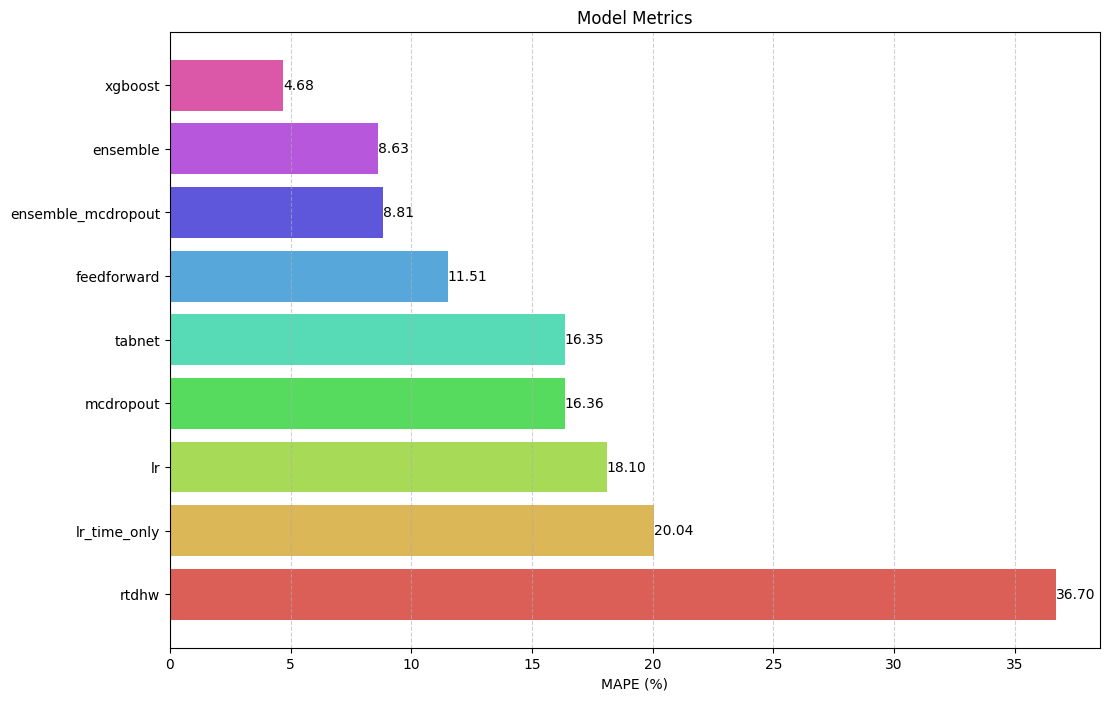

In [72]:
metrics = calculate_metrics(dfs)
plot_MAPE(metrics, std=False)

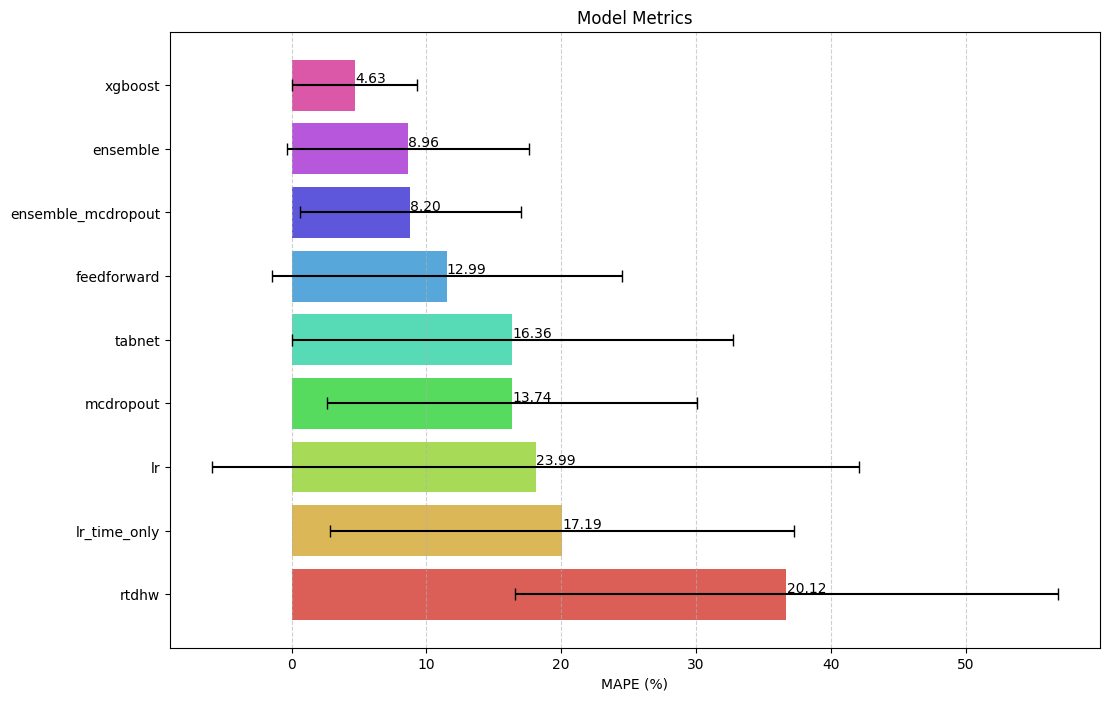

In [73]:
plot_MAPE(metrics)

# Errors

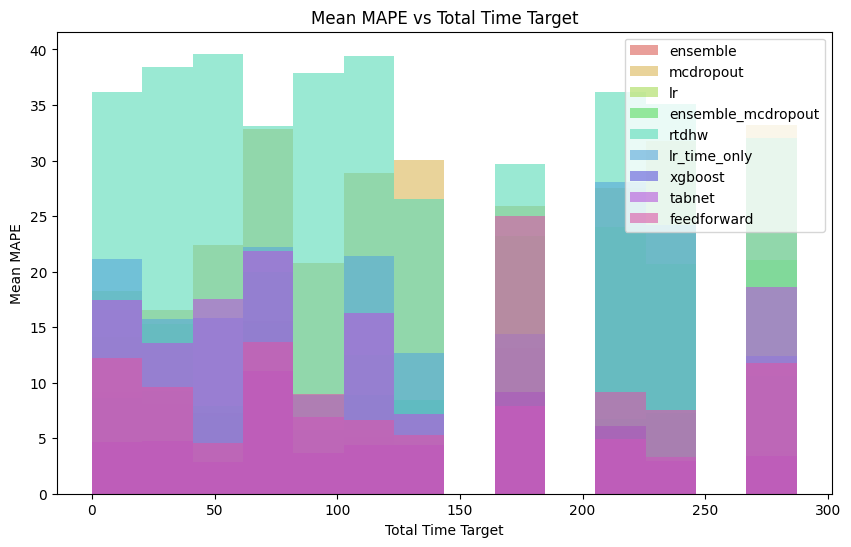

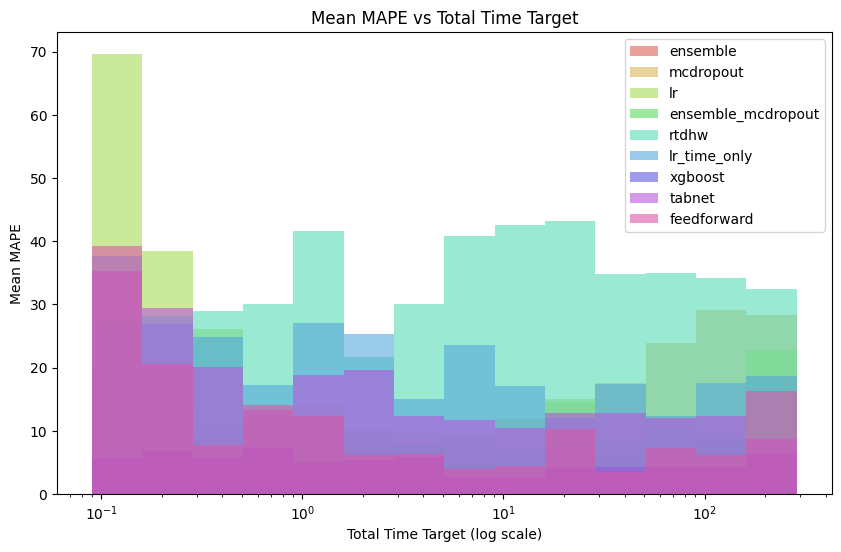

In [74]:
plot_errors(dfs)
plot_errors(dfs, log_scale=True)

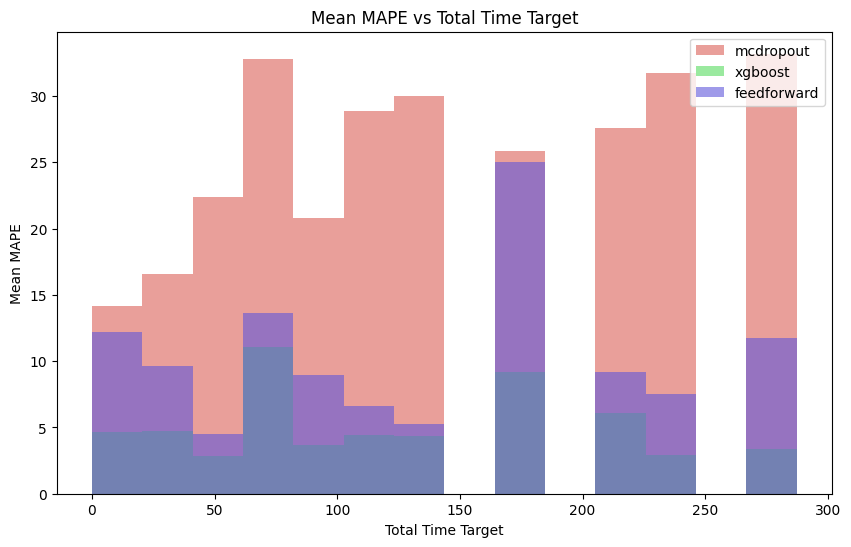

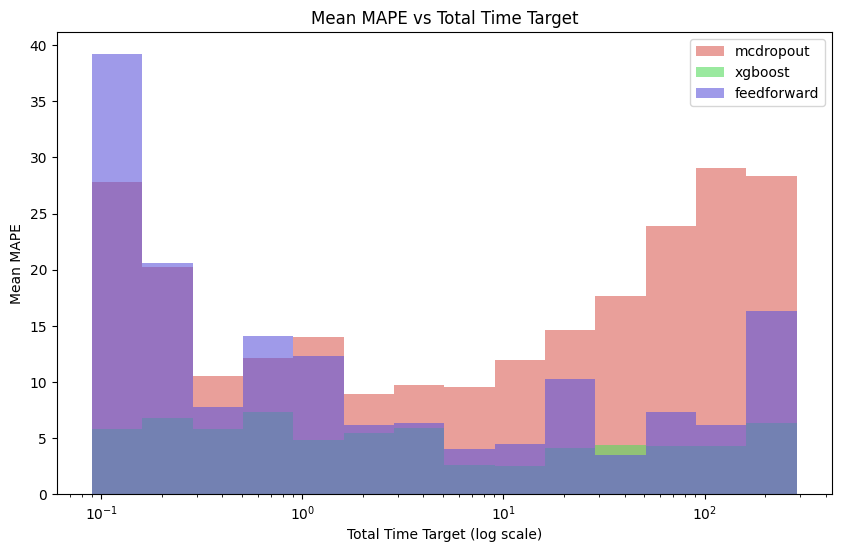

In [75]:
plot_errors(dfs, models=["xgboost", "feedforward", "mcdropout"])
plot_errors(dfs, models=["xgboost", "feedforward", "mcdropout"], log_scale=True)

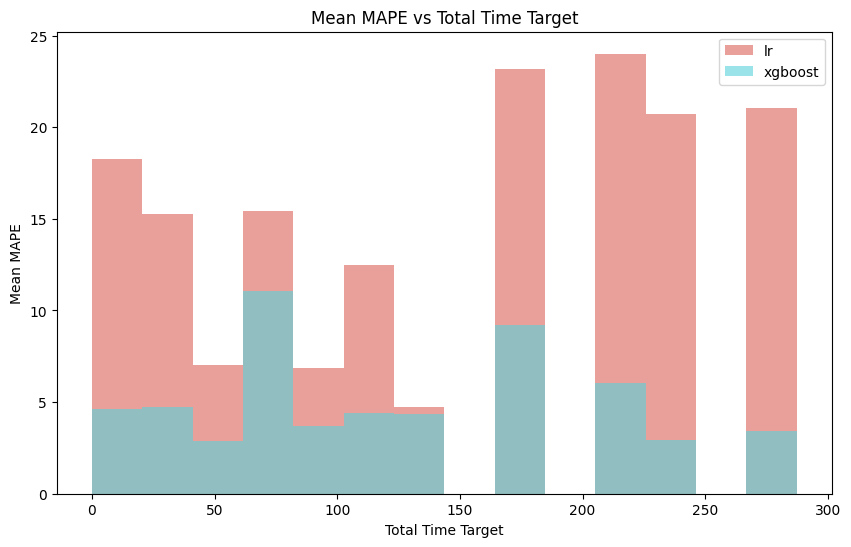

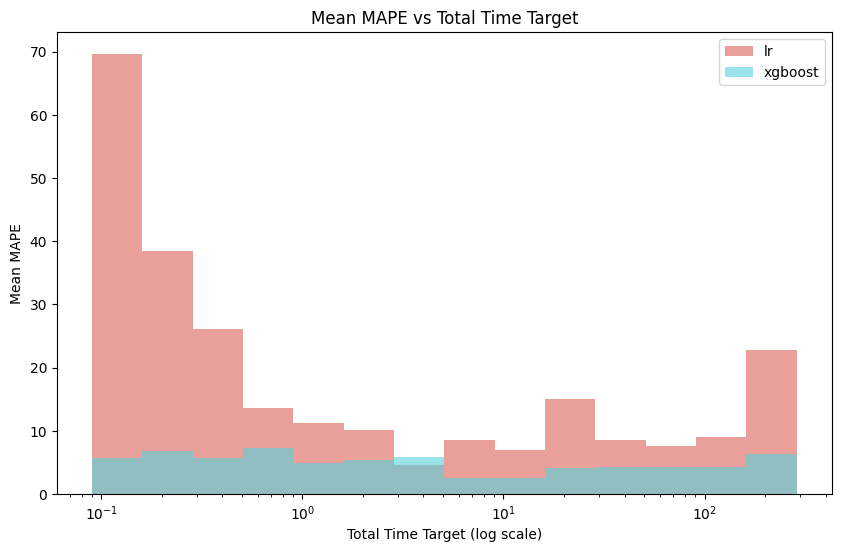

In [76]:
plot_errors(dfs, models=["xgboost", "lr"])
plot_errors(dfs, models=["xgboost", "lr"], log_scale=True)

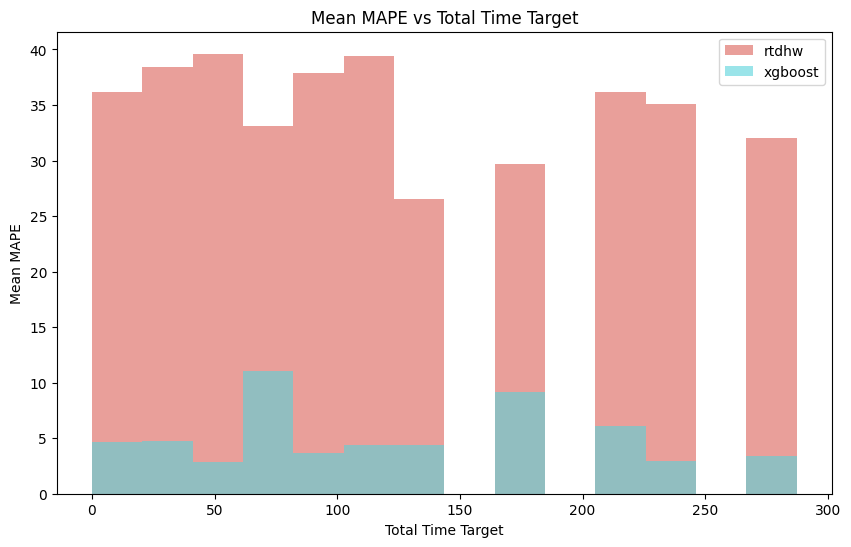

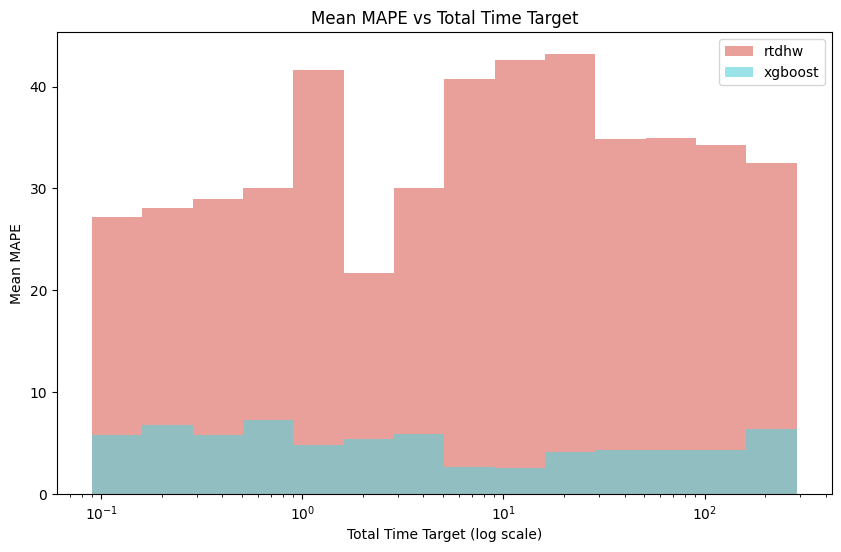

In [77]:
plot_errors(dfs, models=["xgboost", "rtdhw"])
plot_errors(dfs, models=["xgboost", "rtdhw"], log_scale=True)